# Modify initial conditions

Warm up Amundsen ice shelf regions by +0.5 deg

Cool down Weddell ice shelf by -0.3 deg uniformly

Leave the rest....

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from dask.distributed import Client


In [2]:
client = Client(threads_per_worker = 1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37717 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37717/status,
Dashboard: /proxy/37717/status,Workers: 28
Total threads: 28,Total memory: 251.19 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45317,Workers: 0
Dashboard: /proxy/37717/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:37319,Total threads: 1
Dashboard: /proxy/39805/status,Memory: 8.97 GiB
Nanny: tcp://127.0.0.1:42717,


In [11]:
#open currently used ICs from https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/claire_working/initial-conditions/ACCESSOM2_IC_into_8km_grid.ipynb

IC_current = xr.open_dataset("/g/data/tm70/cy8964/mom6/input/input-8km/ACCESS-OM2_IC_bfilled_smoothedland.nc")

#enc_TS = {"_FillValue": -1.e-20,}
#encoding={"temp": enc_TS, "salt": enc_TS})
IC_new = IC_current.copy()
IC_new

<xarray.Dataset> Size: 7GB
Dimensions:  (depth: 75, nxp: 4320, nyp: 1442)
Coordinates:
  * depth    (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * nxp      (nxp) float64 35kB -280.0 -279.9 -279.8 ... 79.79 79.88 79.96
  * nyp      (nyp) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5
Data variables:
    salt     (depth, nyp, nxp) float64 4GB ...
    temp     (depth, nyp, nxp) float64 4GB ...
Attributes:
    description:  Initial conditions of potential temperature and practical s...

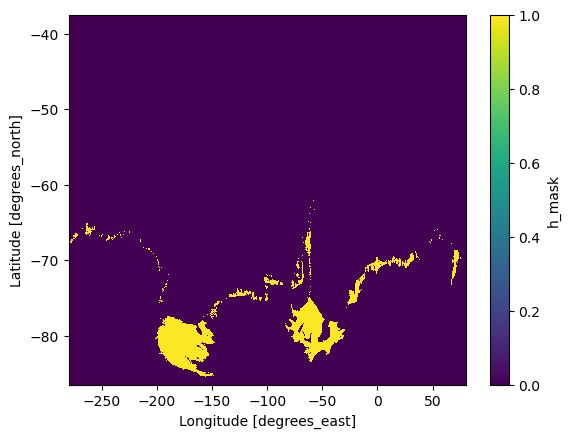

In [4]:
ice_shelf_mask = xr.open_dataset('/g/data/tm70/cy8964/mom6/input/input-8km/150925/ice_thickness_Charrassin_regridded_cropped_add_area_where_iceelev_noGL5m_ADDHMASKFILLTHICK_150925.nc')
ice_shelf_mask.h_mask.plot()

(-78.0, -70.0)

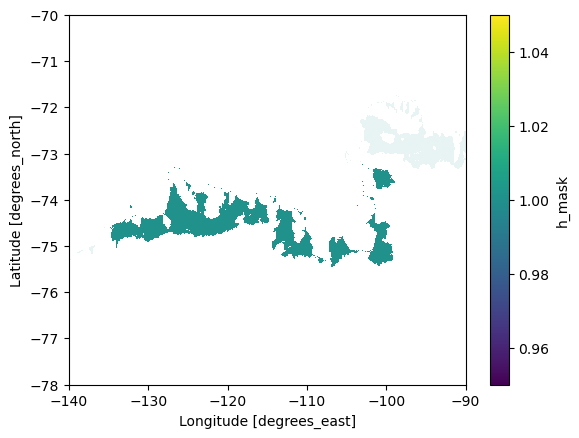

In [5]:
Amundsen_ice_shelf_mask = ice_shelf_mask.h_mask.where(ice_shelf_mask.h_mask.nx>-135
                                               ).where(ice_shelf_mask.h_mask.nx<-98
                                               ).where(ice_shelf_mask.h_mask.ny<-73.2
                                               )
ice_shelf_mask.h_mask.where(ice_shelf_mask.h_mask>0).plot(alpha = 0.1, add_colorbar = False)
Amundsen_ice_shelf_mask.where(Amundsen_ice_shelf_mask>0).plot()
plt.xlim(-140,-90)
plt.ylim(-78,-70)

(-84.0, -72.8)

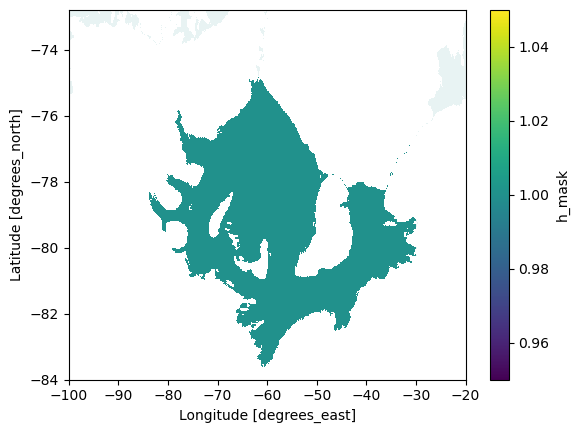

In [6]:
Weddell_ice_shelf_mask = ice_shelf_mask.h_mask.where(ice_shelf_mask.h_mask.nx>-90
                                               ).where(ice_shelf_mask.h_mask.nx<-30
                                               ).where(ice_shelf_mask.h_mask.ny<-74.8
                                               )
ice_shelf_mask.h_mask.where(ice_shelf_mask.h_mask>0).plot(alpha = 0.1, add_colorbar = False)
Weddell_ice_shelf_mask.where(Weddell_ice_shelf_mask>0).plot()
plt.xlim(-100,-20)
plt.ylim(-84,-72.8)

In [7]:
Weddell_ice_shelf_mask = Weddell_ice_shelf_mask.rename({'ny':'nyp','nx':'nxp'})
Amundsen_ice_shelf_mask = Amundsen_ice_shelf_mask.rename({'ny':'nyp','nx':'nxp'})


In [12]:
IC_new["temp"] = IC_new.temp.where(Weddell_ice_shelf_mask!=1).fillna(0) + \
                 (IC_new.temp.where(Weddell_ice_shelf_mask==1) - 0.3).fillna(0)
IC_new["temp"] = IC_new.temp.where(Amundsen_ice_shelf_mask!=1).fillna(0) + \
                 (IC_new.temp.where(Amundsen_ice_shelf_mask==1) + 0.5).fillna(0)
IC_new

<xarray.Dataset> Size: 7GB
Dimensions:  (depth: 75, nxp: 4320, nyp: 1442)
Coordinates:
  * depth    (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * nxp      (nxp) float64 35kB -280.0 -279.9 -279.8 ... 79.79 79.88 79.96
  * nyp      (nyp) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5
Data variables:
    salt     (depth, nyp, nxp) float64 4GB ...
    temp     (depth, nyp, nxp) float64 4GB 0.2893 0.2879 0.2868 ... 1.135 1.135
Attributes:
    description:  Initial conditions of potential temperature and practical s...

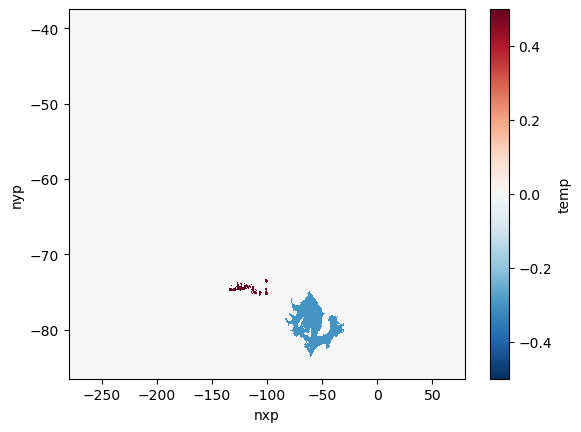

In [13]:
(IC_new.temp.mean('depth') - IC_current.temp.mean('depth')).plot()

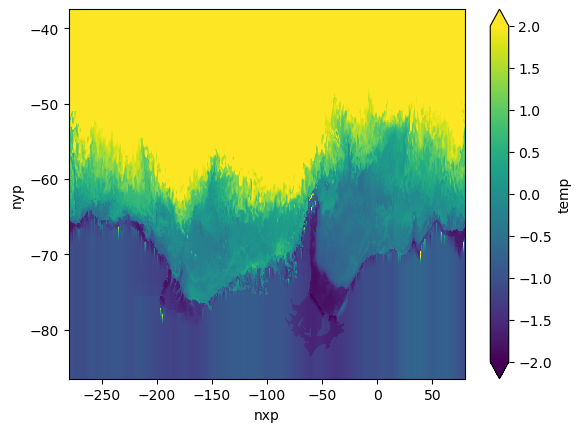

In [15]:
IC_new.temp.mean('depth').plot(vmax = 2, vmin = -2)

In [17]:
IC_new.attrs['description'] = 'Initial conditions of potential temperature and practical salinity taken from start of Jan of second year of ACCESS-OM2-01-RYF output, restarted from WOA13. Interpolated from 1/10th to 1/12th degree by nearest neighbour interpolation and extended southwards using smoothing to avoid cross-Antarctic peninsula leakage. Notebook https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/claire_working/initial-conditions/ACCESSOM2_IC_into_8km_grid.ipynb . Temperatures in Amundsen sector ice shelves are manually shifted by +0.5degC and Weddell ice shelf by -0.3degC to improve spin up speed in https://github.com/claireyung/mom6-panAn-iceshelf-tools/blob/claire_working/initial-conditions/spatial-modifications-to-IC.ipynb.' 
IC_new

<xarray.Dataset> Size: 7GB
Dimensions:  (depth: 75, nxp: 4320, nyp: 1442)
Coordinates:
  * depth    (depth) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * nxp      (nxp) float64 35kB -280.0 -279.9 -279.8 ... 79.79 79.88 79.96
  * nyp      (nyp) float64 12kB -86.49 -86.47 -86.45 ... -37.63 -37.56 -37.5
Data variables:
    salt     (depth, nyp, nxp) float64 4GB ...
    temp     (depth, nyp, nxp) float64 4GB 0.2893 0.2879 0.2868 ... 1.135 1.135
Attributes:
    description:  Initial conditions of potential temperature and practical s...

In [18]:
enc_TS = {"_FillValue": -1.e-20,}

IC_new.to_netcdf("/g/data/x77/cy8964/mom6/input/input-8km/ACCESS-OM2_IC_bfilled_smoothedland_am_wed_adjust.nc", encoding={"temp": enc_TS, "salt": enc_TS})